# Constructing an Interaction Prior based on Receptor-Ligand Gene Expression

In [1]:
import numpy as np
import pandas as pd
import pickle5 as pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import omnipath
from tqdm import tqdm_notebook
import scanpy as sc

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
experiment = 'CARD'

Load gene expression data

In [3]:
hours_post_coculture = [0, 5/60, 15/60, 30/60, 1, 2, 4, 8.5, 12.5, 20.5]
hours_post_coculture = {i: hour for i, hour in enumerate(hours_post_coculture)}
cell_types_to_cluster_numbers = {
    'Other CD8+ T cells': [19,28],
    'MEC1 cells': [1,7,8,10,16,17,22,23,24],
    'Activated T cells': [3,12,14],
    'Exhausted T cells': [0,6,9,11,15,21,26]
}
cluster_numbers_to_cell_types = {cluster_number: cell_type 
                                 for cell_type, cluster_numbers in cell_types_to_cluster_numbers.items()
                                 for cluster_number in cluster_numbers}

gene_exp_df = pickle.load(open('data/CAR-T ratios and umap/data_df_revised_clusters.pkl', 'rb'))
# Filter to experiment
gene_exp_df = gene_exp_df[gene_exp_df.index.str.startswith(experiment)]
gene_exp_df = gene_exp_df[gene_exp_df['cluster_number'].isin(cluster_numbers_to_cell_types.keys())]
gene_exp_df['cell_type'] = gene_exp_df['cluster_number'].replace(cluster_numbers_to_cell_types)
gene_exp_df['timestamp'] = [int(index_split[1][1]) 
                       for index_split in gene_exp_df.index.str.split('_')]
gene_exp_df['timestamp'] = gene_exp_df['timestamp'].replace(hours_post_coculture)
genes = gene_exp_df.columns[:-3]
gene_exp_df

,MIR1302-2HG,AL627309.1,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,AL645608.3,SAMD11,NOC2L,...,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC233755.1,AC240274.1,cluster_number,cell_type,timestamp
CARD_T7_AAACCTGAGAATGTGT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-1.060079,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,MEC1 cells,8.50
CARD_T7_AAACCTGAGACTCGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,22,MEC1 cells,8.50
CARD_T2_AAACCTGAGATGTAAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,0.25
CARD_T9_AAACCTGAGCTGTTCA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,20.50
CARD_T9_AAACCTGAGTACGTAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,20.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARD_T8_TTTGTCAGTTACGACT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,12.50
CARD_T7_TTTGTCATCAGCTCTC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.556825,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,8.50
CARD_T7_TTTGTCATCCGTTGCT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.413217,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,Activated T cells,8.50
CARD_T6_TTTGTCATCCTCGCAT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-1.109225,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,26,Exhausted T cells,4.00


Filter genes with low expression

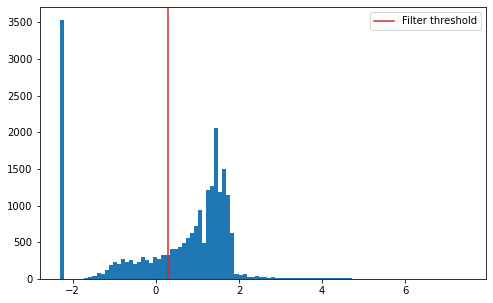

In [4]:
threshold = 0.3

plt.figure(figsize=(8, 5))
n, bins, _ = plt.hist(gene_exp_df[genes].max(), bins=100)
plt.axvline(threshold, label='Filter threshold', c='tab:red')
plt.legend()

In [5]:
print("Percent genes removed:", (gene_exp_df[genes].max() <= threshold).mean() * 100)

gene_filter = (gene_exp_df[genes].max() <= threshold)
genes = genes[~gene_filter]
gene_exp_df = gene_exp_df.drop(columns=gene_filter[gene_filter].index)
gene_exp_df

Percent genes removed: 33.991208396878086


,AL669831.5,LINC00115,NOC2L,KLHL17,HES4,ISG15,AL645608.2,AGRN,AL645608.9,C1orf159,...,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC240274.1,cluster_number,cell_type,timestamp
CARD_T7_AAACCTGAGAATGTGT,-2.302585,-2.302585,-1.060079,-2.302585,-2.302585,-0.175205,-2.302585,-2.302585,-2.302585,-2.302585,...,2.221142,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,MEC1 cells,8.50
CARD_T7_AAACCTGAGACTCGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.705379,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,22,MEC1 cells,8.50
CARD_T2_AAACCTGAGATGTAAC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.010899,-2.302585,-2.302585,-2.302585,-2.302585,...,3.375154,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,0.25
CARD_T9_AAACCTGAGCTGTTCA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.563830,-2.302585,-2.302585,-2.302585,-2.302585,...,2.813845,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,20.50
CARD_T9_AAACCTGAGTACGTAA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-0.272696,-2.302585,-2.302585,-2.302585,-2.302585,...,3.429188,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,20.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARD_T8_TTTGTCAGTTACGACT,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.418453,-2.302585,-2.302585,-2.302585,-2.302585,...,3.063117,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,12.50
CARD_T7_TTTGTCATCAGCTCTC,-2.302585,-2.302585,-0.556825,-2.302585,-2.302585,-0.556825,-2.302585,-2.302585,-2.302585,-2.302585,...,3.397879,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,8.50
CARD_T7_TTTGTCATCCGTTGCT,-2.302585,-2.302585,0.413217,-2.302585,-2.302585,0.413217,-2.302585,-2.302585,-2.302585,-2.302585,...,3.239075,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,Activated T cells,8.50
CARD_T6_TTTGTCATCCTCGCAT,-2.302585,-2.302585,-1.109225,-2.302585,-2.302585,0.019074,-2.302585,-2.302585,-2.302585,-2.302585,...,3.825006,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,26,Exhausted T cells,4.00


Filter clusters by percent of cells in cluster

Clusters after filtering: ['Activated T cells', 'Exhausted T cells', 'MEC1 cells', 'Other CD8+ T cells']


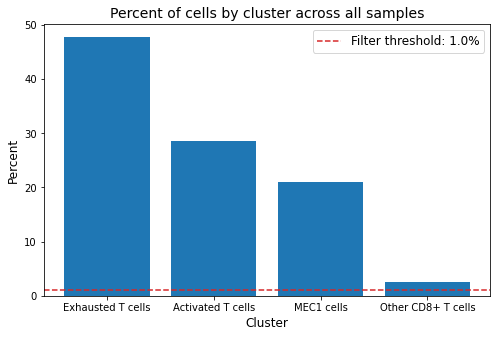

In [6]:
threshold = 0.01
cluster_counts = gene_exp_df['cell_type'].value_counts(normalize=True)

plt.figure(figsize=(8, 5))
plt.bar(range(len(cluster_counts)), cluster_counts.values * 100)
plt.axhline(threshold*100, color='tab:red', linestyle='--', 
            label=f'Filter threshold: {threshold * 100}%')
plt.xticks(range(len(cluster_counts)), cluster_counts.index)
plt.title('Percent of cells by cluster across all samples', fontsize=14)
plt.ylabel('Percent', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.legend(fontsize=12, loc='upper right')

clusters_of_interest = sorted(cluster_counts[cluster_counts >= threshold].index)
print('Clusters after filtering:', list(clusters_of_interest))

In [7]:
len(clusters_of_interest)

4

Load receptor-ligand pairs from Omnipath DB

In [8]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
0,P0DP23,Q13507,CALM1,TRPC3,True,False,True,True,False,True,6,CellTalkDB:11248050;HPRD:15104175;TRIP:1124805...,CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;LRdb;TR...,11248050;11290752;12601176;15104175;18215135,5,7,5
1,P60903,Q9H1D0,S100A10,TRPV6,True,True,False,True,True,False,5,CellTalkDB:18187190;HPRD:12660155;TRIP:1266015...,CellTalkDB;HPRD;TRIP,12660155;16189514;18187190,3,3,3
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
3,P46531,Q9Y219,NOTCH1,JAG2,True,False,True,False,False,False,3,HPRD:11006133;NetPath:11006133;SPIKE:15358736,Baccin2019;CellCall;HPRD;NetPath;Ramilowski201...,11006133;15358736,2,6,5
4,Q9Y219,P46531,JAG2,NOTCH1,True,True,True,True,True,False,19,Baccin2019:1100613311006130;CellChatDB:2235346...,Baccin2019;CellCall;CellChatDB;CellPhoneDB;Cel...,10958687;11006133;1100613311006130;16921404;18...,11,32,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8345,P18510,P01583,IL1RN,IL1A,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
8346,P18510,P01584,IL1RN,IL1B,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors;Wang,None,None,2,2
8347,P23467,COMPLEX:P05556_P08648,PTPRB,ITGA5_ITGB1,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1
8348,Q969E1,Q9UBU3,LEAP2,GHRL,True,False,True,True,False,True,0,NaN,CellChatDB-cofactors,None,None,1,1


In [9]:
rl_pairs = omnipath.interactions.LigRecExtra().get(genesymbols=True)
rl_pairs = rl_pairs.drop_duplicates(subset=['source_genesymbol', 'target_genesymbol'])

# Filter RL pairs to genes in gene expression data
rl_pairs = rl_pairs[(rl_pairs['source_genesymbol'].isin(gene_exp_df.columns)) & 
                    (rl_pairs['target_genesymbol'].isin(gene_exp_df.columns))]
rl_pairs

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,references_stripped,n_references,n_sources,n_primary_sources
2,O60674,P19235,JAK2,EPOR,True,True,False,True,True,False,21,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12...,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;...,10579919;10660611;11443118;11779507;12027890;1...,13,22,14
7,P05019,P08069,IGF1,IGF1R,True,True,False,True,True,False,27,Baccin2019:1852007;Baccin2019:2877871;CA1:8408...,Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB...,11287679;12067807;14604834;185;1852007;1902995...,15,42,26
8,P46531,P78504,NOTCH1,JAG1,True,True,False,False,False,False,16,Baccin2019:11006133;BioGRID:11006133;DIP:18660...,Baccin2019;BioGRID;CellCall;DIP;HPMR;HPRD;IntA...,11006133;16713569;17537801;18495817;18660822;2...,9,14,13
9,P78504,P46531,JAG1,NOTCH1,True,True,True,True,True,False,36,ACSN:22330899;ACSN:22363130;Baccin2019:7697721...,ACSN;Baccin2019;BioGRID;CellCall;CellChatDB;Ce...,10958687;11;11006133;15137944;16713569;1692140...,20,39,27
11,Q96HF1,P04628,SFRP2,WNT1,True,False,True,True,False,True,2,HPRD:10654605;SPIKE:10654605,CellChatDB-cofactors;HPRD;SPIKE;Wang,10654605,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8296,Q01974,Q9NPG1,ROR2,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8297,P34925,Q9NPG1,RYK,FZD3,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8304,Q01974,O60353,ROR2,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1
8305,P34925,O60353,RYK,FZD6,True,True,False,True,True,False,0,NaN,CellChatDB-cofactors,None,None,1,1


Identify DEGs per sample, per cluster

In [10]:
timestamp = 8.5
clusters_of_interest = ['MEC1 cells', 'Other CD8+ T cells', 'Activated T cells', 'Exhausted T cells']

sample_gene_exp_df = gene_exp_df[(gene_exp_df['timestamp'] == timestamp) & 
                                 (gene_exp_df['cell_type'].isin(clusters_of_interest))]
clusters_with_more_than_1_cell = sample_gene_exp_df['cell_type'].value_counts()\
                                    [sample_gene_exp_df['cell_type'].value_counts() > 1].index
sample_gene_exp_df = sample_gene_exp_df[sample_gene_exp_df['cell_type'].\
                        isin(clusters_with_more_than_1_cell)]
sample_adata = sc.AnnData(sample_gene_exp_df[genes], 
                          obs=sample_gene_exp_df[['cell_type']].astype('str'))
sample_adata

AnnData object with n_obs × n_vars = 2276 × 14716
    obs: 'cell_type'

In [11]:
sc.tl.rank_genes_groups(sample_adata, groupby='cell_type', method='wilcoxon', key_added='wilcoxon')
sample_adata

/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


AnnData object with n_obs × n_vars = 2276 × 14716
    obs: 'cell_type'
    uns: 'wilcoxon'

In [12]:
sample_cluster_deg_df = sc.get.rank_genes_groups_df(sample_adata, group="Exhausted T cells", key='wilcoxon')
top_degs = sample_cluster_deg_df[(sample_cluster_deg_df['pvals_adj'] <= 0.01) & 
                                 (sample_cluster_deg_df['scores'] >= 0)]
top_degs.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,EIF5A,40.580551,2.666401,0.0,0.0
1,C1QBP,40.298027,3.413199,0.0,0.0
2,FABP5,39.995117,NaN,0.0,0.0
3,PSMA7,39.583916,1.307245,0.0,0.0
4,POLR2K,39.064575,NaN,0.0,0.0
5,RBM8A,39.027287,3.844337,0.0,0.0
6,IL2RA,39.022121,NaN,0.0,0.0
7,GZMB,38.932899,NaN,0.0,0.0
8,TNFRSF4,38.452827,NaN,0.0,0.0
9,SNU13,38.249603,1.543696,0.0,0.0


Text(0.5, 1.0, 'Distribution of TIGIT at time 8.5')

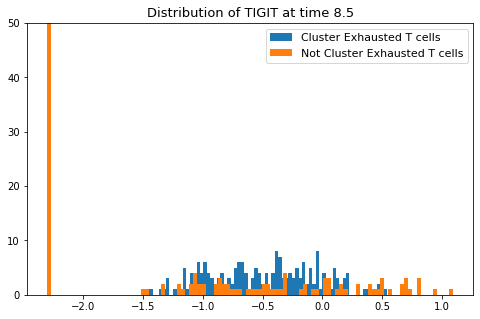

In [13]:
timestamp = 8.5
cluster = 'Exhausted T cells'
gene = 'TIGIT'

sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
sample_gene_exp_in_cluster = sample_gene_exp_df.loc[sample_gene_exp_df['cell_type'] == cluster, gene]
sample_gene_exp_out_of_cluster = sample_gene_exp_df.loc[sample_gene_exp_df['cell_type'] != cluster, gene]
plt.figure(figsize=(8, 5))
plt.hist(sample_gene_exp_in_cluster, bins=100, label=f'Cluster {cluster}')
plt.hist(sample_gene_exp_out_of_cluster, bins=100, label=f'Not Cluster {cluster}')
plt.ylim([0, 50])
plt.legend(fontsize=11)
plt.title(f'Distribution of {gene} at time {timestamp}', fontsize=13)

Identify DEGs per sample, per cluster, for all samples and clusters

In [14]:
sample_to_cluster_to_degs = dict()

for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):
    print(timestamp)
    sample_to_cluster_to_degs[timestamp] = dict()
    sample_gene_exp_df = gene_exp_df[(gene_exp_df['timestamp'] == timestamp) & 
                                     (gene_exp_df['cell_type'].isin(clusters_of_interest))]
    clusters_with_more_than_1_cell = sample_gene_exp_df['cell_type'].value_counts()\
                                        [sample_gene_exp_df['cell_type'].value_counts() > 1].index
    sample_gene_exp_df = sample_gene_exp_df[sample_gene_exp_df['cell_type'].isin(clusters_with_more_than_1_cell)]
    if sample_gene_exp_df.shape[0] == 0: continue
    sample_adata = sc.AnnData(sample_gene_exp_df[genes], 
                              obs=sample_gene_exp_df[['cell_type']].astype('str'))
    sc.tl.rank_genes_groups(sample_adata, groupby='cell_type', method='wilcoxon', key_added='wilcoxon')
    for cluster in clusters_of_interest:
        if cluster not in clusters_with_more_than_1_cell: 
            sample_to_cluster_to_degs[timestamp][cluster] = []
            continue
        sample_cluster_deg_df = sc.get.rank_genes_groups_df(sample_adata, group=str(cluster), key='wilcoxon')
        top_degs = sample_cluster_deg_df[(sample_cluster_deg_df['pvals_adj'] <= 0.01) & 
                                         (sample_cluster_deg_df['scores'] >= 0)]
        sample_to_cluster_to_degs[timestamp][cluster] = list(zip(top_degs['names'], top_degs['scores']))

/var/folders/tg/shx3906s1x9fz1fx92mk5fc80000gn/T/ipykernel_67380/803265464.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for timestamp in tqdm_notebook(gene_exp_df['timestamp'].unique()):


  0%|          | 0/10 [00:00<?, ?it/s]

8.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

0.25
20.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


12.5


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


1.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


4.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


0.5
0.08333333333333333


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

2.0
0.0


/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/shouvikmani/miniforge3/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] =

Summary of highest-scoring DEGs across all samples, by cluster

In [15]:
cluster_deg_counts = {cluster: {} for cluster in clusters_of_interest}

for sample, cluster_degs in sample_to_cluster_to_degs.items():
    for cluster, degs in cluster_degs.items():
        for gene, score in degs:
            if gene in cluster_deg_counts[cluster]:
                cluster_deg_counts[cluster][gene] += score
            else:
                cluster_deg_counts[cluster][gene] = score
                
top_cluster_degs = pd.DataFrame()
for cluster in clusters_of_interest:
    degs_sorted_by_freq = pd.DataFrame(cluster_deg_counts[cluster].items()).sort_values(1, ascending=False)
    top_cluster_degs[cluster] = degs_sorted_by_freq.iloc[:25, 0].values
    
top_cluster_degs

,MEC1 cells,Other CD8+ T cells,Activated T cells,Exhausted T cells
0,IGKV4-1,PFN1,GSTK1,PSMB1
1,IGHM,CFL1,FXYD5,IL2RA
2,MT-ND2,STMN1,RPS4Y1,PSMB6
3,NCF1,HMGN2,CD52,TNFRSF4
4,MZB1,PTTG1,TPT1,EIF5A
5,ARPC5L,ARPC2,IFITM1,SLC25A3
6,MS4A1,H2AFV,IFITM2,GZMB
7,IGKC,TMSB10,RGS10,PSMA7
8,LAT2,VIM,EIF3F,NDUFV2
9,CHCHD10,CORO1A,SSR2,KIF2A


Create interaction score prior matrix for one sample

In [16]:
timestamp = 8.5
sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
sample_gene_exp_df

,AL669831.5,LINC00115,NOC2L,KLHL17,HES4,ISG15,AL645608.2,AGRN,AL645608.9,C1orf159,...,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC240274.1,cluster_number,cell_type,timestamp
CARD_T7_AAACCTGAGAATGTGT,-2.302585,-2.302585,-1.060079,-2.302585,-2.302585,-0.175205,-2.302585,-2.302585,-2.302585,-2.302585,...,2.221142,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10,MEC1 cells,8.5
CARD_T7_AAACCTGAGACTCGGA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,3.705379,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,22,MEC1 cells,8.5
CARD_T7_AAACCTGTCGTGACAT,-2.302585,-2.302585,-0.197644,-2.302585,-2.302585,0.432642,-2.302585,-2.302585,-0.197644,-2.302585,...,3.364758,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,8.5
CARD_T7_AAACGGGAGTAATCCC,-2.302585,-2.302585,-1.219832,-2.302585,-1.219832,-0.126563,-2.302585,-2.302585,-2.302585,-2.302585,...,3.463564,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,17,MEC1 cells,8.5
CARD_T7_AAACGGGCACTGTGTA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,1.056034,-2.302585,-2.302585,-2.302585,-2.302585,...,3.293036,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3,Activated T cells,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CARD_T7_TTTGTCAGTCGTTGTA,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.449237,-2.302585,-2.302585,-2.302585,-0.529263,...,3.313683,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,Activated T cells,8.5
CARD_T7_TTTGTCAGTCTTCGTC,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.393192,-2.302585,-2.302585,-2.302585,-2.302585,...,3.036180,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,26,Exhausted T cells,8.5
CARD_T7_TTTGTCATCAGCTCTC,-2.302585,-2.302585,-0.556825,-2.302585,-2.302585,-0.556825,-2.302585,-2.302585,-2.302585,-2.302585,...,3.397879,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,6,Exhausted T cells,8.5
CARD_T7_TTTGTCATCCGTTGCT,-2.302585,-2.302585,0.413217,-2.302585,-2.302585,0.413217,-2.302585,-2.302585,-2.302585,-2.302585,...,3.239075,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,12,Activated T cells,8.5


In [17]:
sample_cluster_avg_gene_exp = sample_gene_exp_df.groupby('cell_type').mean()[genes]
sample_cluster_avg_gene_exp

,AL669831.5,LINC00115,NOC2L,KLHL17,HES4,ISG15,AL645608.2,AGRN,AL645608.9,C1orf159,...,MT-ND4,MT-ND5,MT-ND6,MT-CYB,MAFIP,AC011043.1,AL592183.1,AL354822.1,AC004556.1,AC240274.1
cell_type,,,,,,,,,,,,,,,,,,,,,
Activated T cells,-2.295036,-2.297899,-2.032635,-2.302585,-2.299759,0.653896,-2.302585,-2.291965,-2.295036,-2.292958,...,1.608152,1.071511,-1.056648,3.473679,-2.302585,-2.302585,-2.289416,-2.291043,-2.302585,-2.298712
Exhausted T cells,-2.288985,-2.273766,-1.351562,-2.292366,-2.238461,-0.220074,-2.302585,-2.289137,-2.282625,-2.246795,...,1.542468,1.831566,-0.701982,3.158110,-2.302585,-2.299711,-2.298403,-2.294435,-2.300882,-2.299043
MEC1 cells,-2.289371,-2.288156,-0.805576,-2.280728,-2.208079,-0.012658,-2.302585,-2.250987,-2.276004,-2.204476,...,2.658393,2.370946,-0.119066,3.468581,-2.302585,-2.302585,-2.302585,-2.289244,-2.302585,-2.298030
Other CD8+ T cells,-2.302585,-2.269847,-2.035956,-2.302585,-2.302585,0.277828,-2.302585,-2.274112,-2.302585,-2.274112,...,1.657509,1.266349,-0.085236,3.540929,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585


In [18]:
cluster_interaction_score_matrix = np.full((len(clusters_of_interest), len(clusters_of_interest)), 
                                           np.nan)

clusters_rl_gene_exp = []
for row, receiver_cluster in enumerate(clusters_of_interest):
    for col, sender_cluster in enumerate(clusters_of_interest):
        if (receiver_cluster in sample_cluster_avg_gene_exp.index and 
            sender_cluster in sample_cluster_avg_gene_exp.index):
            ligand_gene_expressions = sample_cluster_avg_gene_exp.loc[sender_cluster][rl_pairs['source_genesymbol']]
            receptor_gene_expressions = sample_cluster_avg_gene_exp.loc[receiver_cluster][rl_pairs['target_genesymbol']]
            # Filter down to highly co-expressed and differentially-expressed RL pairs
            sample_sender_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][sender_cluster]]
            sample_receiver_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][receiver_cluster]]
            rl_interaction_thresholded = \
                (ligand_gene_expressions.index.isin(sample_sender_cluster_degs) & 
                 receptor_gene_expressions.index.isin(sample_receiver_cluster_degs))
            for i in np.where(rl_interaction_thresholded)[0]:
                clusters_rl_gene_exp.append({
                    'Source cluster': sender_cluster,
                    'Ligand': ligand_gene_expressions.index[i],
                    'Ligand expression': ligand_gene_expressions[i],
                    'Target cluster': receiver_cluster,
                    'Receptor': receptor_gene_expressions.index[i],
                    'Receptor expression': receptor_gene_expressions[i],
                    'Ligand + Receptor expression': ligand_gene_expressions[i] + receptor_gene_expressions[i]
                })
            cluster_interaction_score_matrix[row][col] = rl_interaction_thresholded.sum()

Text(0.5, 1.02, 'Cluster interaction scores (time 8.5)')

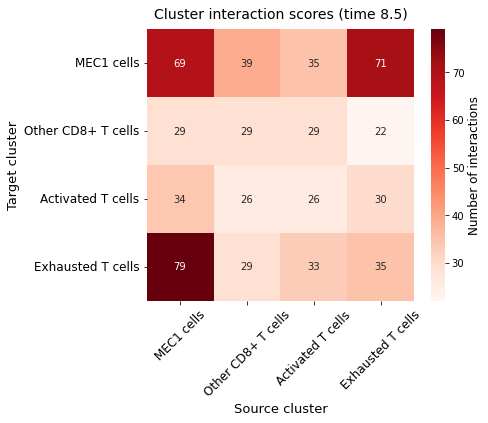

In [19]:
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cluster_interaction_score_matrix, cmap="Reds", annot=True, fmt='.0f', 
                 cbar_kws={'label': 'Number of interactions'})
ax.figure.axes[-1].yaxis.label.set_size(12)
ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_of_interest, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Cluster interaction scores (time {timestamp})', fontsize=14, y=1.02)

In [20]:
def create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, rl_pairs, clusters_of_interest, 
                                             sample_to_cluster_to_degs):
    sample_gene_exp_df = gene_exp_df[gene_exp_df['timestamp'] == timestamp]
    sample_cluster_avg_gene_exp = sample_gene_exp_df.groupby('cell_type').mean()
    cluster_interaction_score_matrix = np.full((len(clusters_of_interest), len(clusters_of_interest)), 
                                               np.nan)
    for row, receiver_cluster in enumerate(clusters_of_interest):
        for col, sender_cluster in enumerate(clusters_of_interest):
            if (receiver_cluster in sample_cluster_avg_gene_exp.index and 
                sender_cluster in sample_cluster_avg_gene_exp.index):
                ligand_gene_expressions = sample_cluster_avg_gene_exp.loc[sender_cluster][rl_pairs['source_genesymbol']]
                receptor_gene_expressions = sample_cluster_avg_gene_exp.loc[receiver_cluster][rl_pairs['target_genesymbol']]
                # Filter down to highly co-expressed and differentially-expressed RL pairs
                sample_sender_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][sender_cluster]]
                sample_receiver_cluster_degs = [gene for gene, score in sample_to_cluster_to_degs[timestamp][receiver_cluster]]
                rl_interaction_thresholded = \
                    (ligand_gene_expressions.index.isin(sample_sender_cluster_degs) & 
                     receptor_gene_expressions.index.isin(sample_receiver_cluster_degs))
                cluster_interaction_score_matrix[row][col] = rl_interaction_thresholded.sum()
    return cluster_interaction_score_matrix

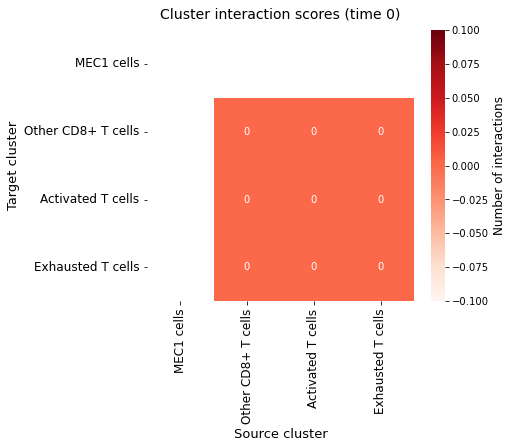

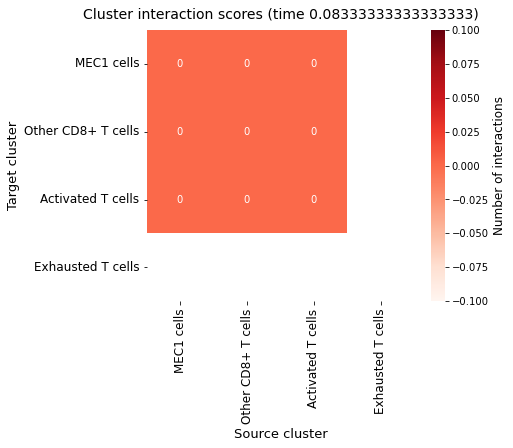

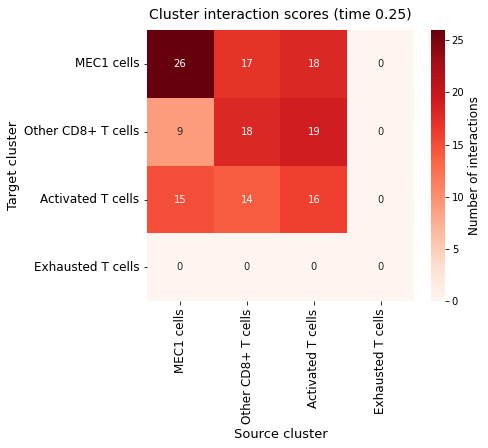

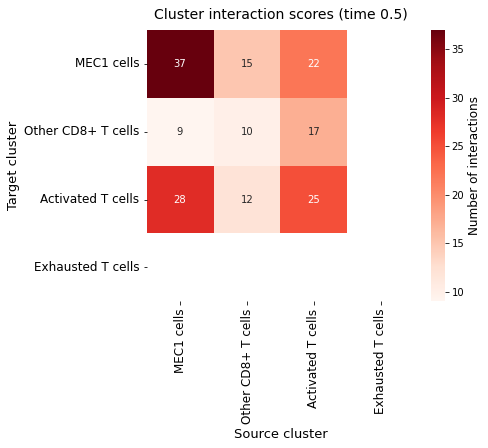

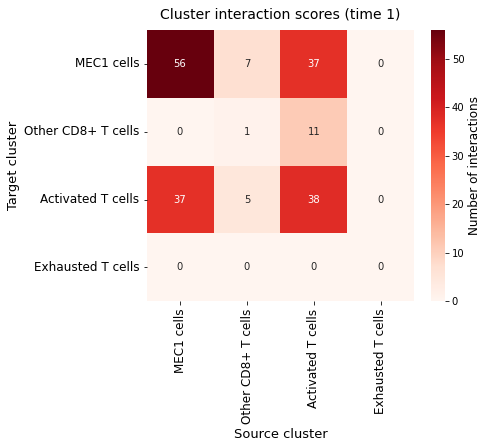

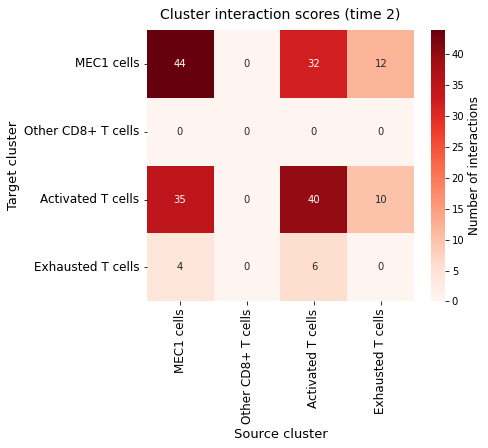

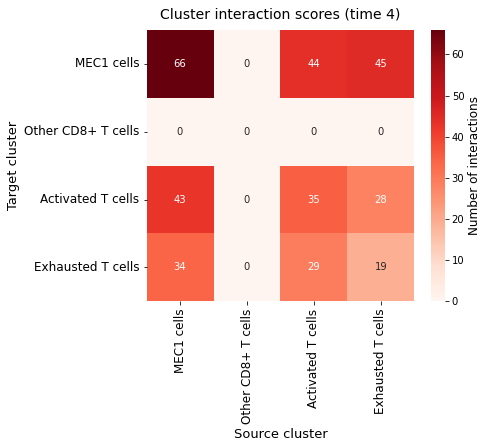

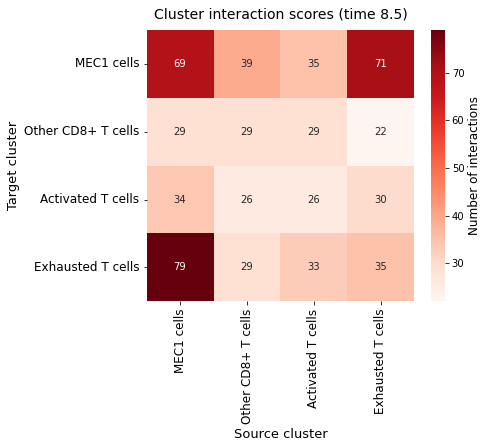

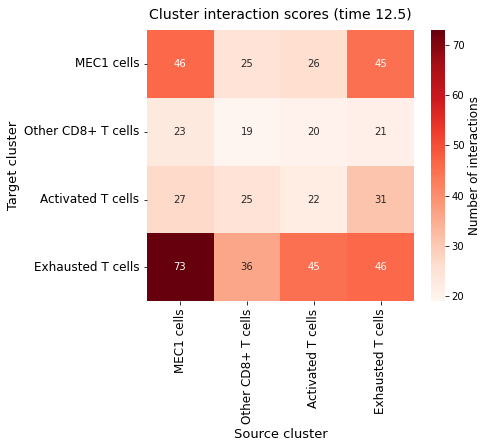

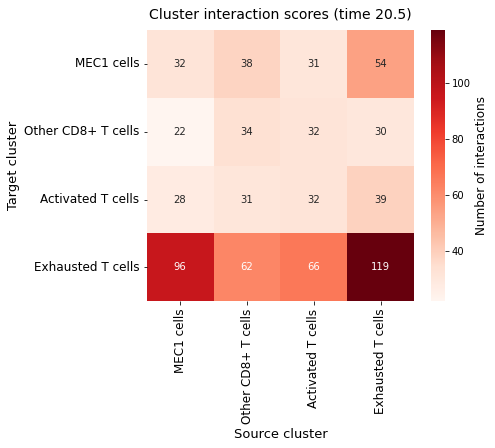

In [21]:
sample_cluster_interaction_score_matrices = {}

for timestamp in hours_post_coculture.values():
    cluster_interaction_score_matrix = create_cluster_interaction_scores_matrix(timestamp, gene_exp_df, 
                                            rl_pairs, clusters_of_interest, sample_to_cluster_to_degs)
    sample_cluster_interaction_score_matrices[timestamp] = cluster_interaction_score_matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cluster_interaction_score_matrix, cmap="Reds", annot=True, fmt='.0f', 
                     cbar_kws={'label': 'Number of interactions'})
    ax.figure.axes[-1].yaxis.label.set_size(12)
    ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
    ax.set_xticklabels(clusters_of_interest, rotation=90, fontsize=12)
    plt.xlabel('Source cluster', fontsize=13)
    plt.ylabel('Target cluster', fontsize=13)
    plt.title(f'Cluster interaction scores (time {timestamp})', fontsize=14, y=1.02)

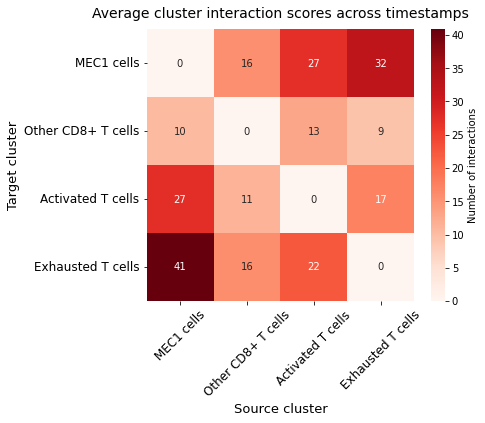

In [22]:
avg_cluster_interaction_score = np.nanmean(
    np.array(list(sample_cluster_interaction_score_matrices.values())), 
    axis=0)
np.fill_diagonal(avg_cluster_interaction_score, 0)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(avg_cluster_interaction_score, cmap="Reds", 
                 annot=True, fmt='.0f', cbar_kws={'label': 'Number of interactions'})
ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_of_interest, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Average cluster interaction scores across timestamps', fontsize=14, y=1.02)
plt.savefig(f'figures/CAR-T/interaction_scores_{experiment}.eps', bbox_inches="tight")

In [23]:
np.save(f'data/CAR-T/interaction_scores_{experiment}.npy', avg_cluster_interaction_score)

Text(0.5, 1.0, 'Distribution of average interaction scores')

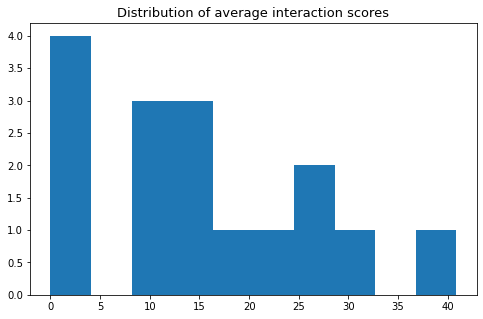

In [24]:
plt.figure(figsize=(8, 5))
plt.hist(avg_cluster_interaction_score.flatten(), bins=10)
plt.title('Distribution of average interaction scores', fontsize=13)

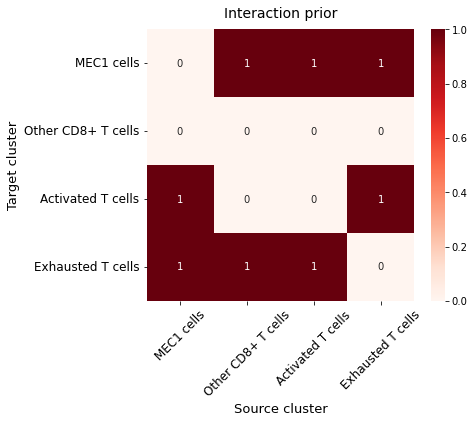

In [33]:
interaction_prior = avg_cluster_interaction_score >= 15

plt.figure(figsize=(6, 5))
ax = sns.heatmap(interaction_prior, cmap="Reds", annot=True)
ax.set_yticklabels(clusters_of_interest, rotation=0, fontsize=12)
ax.set_xticklabels(clusters_of_interest, rotation=45, fontsize=12)
plt.xlabel('Source cluster', fontsize=13)
plt.ylabel('Target cluster', fontsize=13)
plt.title(f'Interaction prior', fontsize=14, y=1.02)
plt.savefig(f'figures/CAR-T/interaction_prior_{experiment}.eps', bbox_inches="tight")

In [34]:
np.save(f'data/CAR-T/interaction_prior_{experiment}.npy', interaction_prior)